In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from skimage import io
from torch.utils import data
from torchvision import transforms
from torch.autograd import Variable

In [2]:
'''Define data load class'''
def getData():
    img = pd.read_csv('test_img.csv',header=None)
    label = pd.read_csv('test_label.csv',header=None)
    return np.squeeze(img.values), np.squeeze(label.values)

class RetinopathyLoader(data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.img_name, self.labels = getData()
        self.transform = transform
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, index):
        image_path = self.root + self.img_name[index]+ '.jpeg'
        self.img = io.imread(image_path)
        self.label = self.labels[index]

        if self.transform:
            self.img = self.transform(self.img)

        return self.img,self.label

In [3]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
])

test_dataset=RetinopathyLoader('./data/', transform=test_transforms)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True,num_workers=0)

> Found 7026 images...


In [4]:
#Load pre-training model

resnet18 = torch.load('./resnet18_7525.pt')
print(resnet18.eval())

# resnet50 = torch.load('./resnet50_7465.pt')
# print(resnet50.eval())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
#Testing function
def evaluate(model,test_dataset, test_loader):
    val_acc=0
    ans=[]
    pre=[]
    for img_test, label_test in test_loader:
        model.eval()   
        model.cuda(0)
        img_test= Variable(img_test).cuda()
        label_test= Variable(label_test).cuda()
        output = model(img_test)
        pred = torch.max(output, 1)[1]
        val_correct = (pred == label_test).sum().item()
        val_acc += val_correct
        ans.extend(label_test.tolist())
        pre.extend(pred.tolist())

    Acc = float(val_acc / (len(test_dataset)))*100
            
    return ans,pre,Acc

In [6]:
#Evaluate
ans,pre,acc=evaluate(resnet18,test_dataset,test_loader) #resnet18
# ans,pre,acc=evaluate(resnet50,test_dataset,test_loader)  #resnet50
print( "Testing accuracy : %.2f" % acc,"%")

Testing accuracy : 75.26 %


Normalized confusion matrix


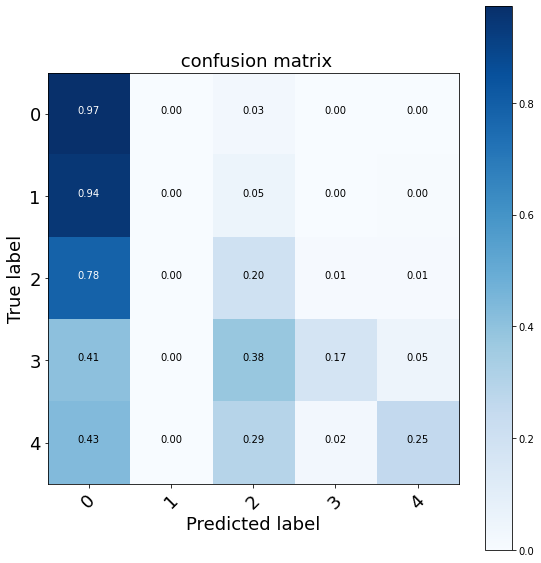

In [7]:
'''Confusion matrix'''
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title,fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=18)
    plt.yticks(tick_marks, classes,fontsize=18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)
    plt.tight_layout()

target_names = [ '0','1','2','3','4' ]

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(ans, pre)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,title=' confusion matrix')
# plt.savefig('Normalized confusion_matrix.jpg',dpi=300)
plt.show()